In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# author:   Jan Hybs

import sys
import math
main = sys.modules['__main__']
import warnings
warnings.filterwarnings('ignore')


from tul.flow123d.experiments import Experiment as Exp
from tul.flow123d.data.base import D as Data
from tul.flow123d.data.base import Norm
from tul.flow123d.utils.stats import norm, drop_row, drop_col, drop_outliers, load_data
from tul.flow123d.data.preprocessing import iqr_filter, ShiftDetection

from IPython.display import display, HTML
from pluck import pluck

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from   matplotlib.colors import LogNorm
import seaborn as sns

import pandas as pd
import scipy.optimize as op
import scipy.stats as st
import numpy as np


np.set_printoptions(precision=4, suppress=False)
np.random.seed(1234)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

blue, green, red, purple, yellow, turquoise = sns.color_palette('deep')

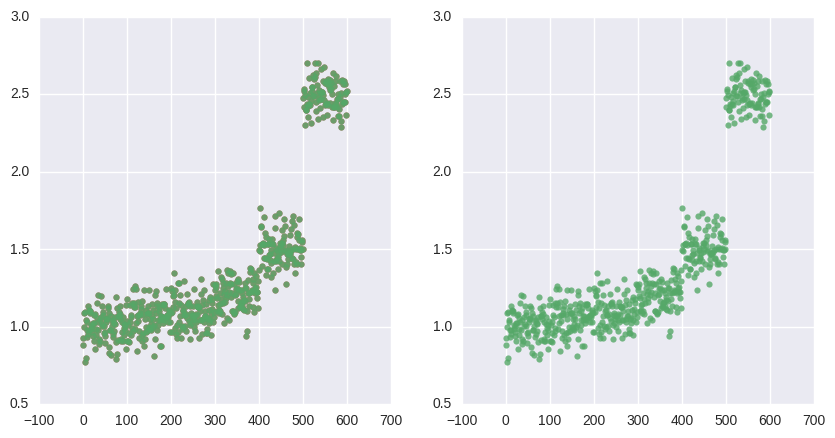

In [2]:
%matplotlib inline

def random_spike(prop=0.95):
    if np.random.rand() >= prop:
        return np.random.randn()
    return 0

def f(x, mu=0.0, sigma=.50, spike_mu=2, spike_prob=5):
    return np.random.normal(mu, sigma) + random_spike(spike_prob) * spike_mu

sigma = 0.1
f = np.vectorize(f)
n = np.arange(100)
y = np.concatenate(
    (
        f(n, 1.00, sigma),
        f(n, 1.05, sigma),
        f(n, 1.10, sigma),
        f(n, 1.20, sigma),
        f(n, 1.50, sigma),
        f(n, 2.50, sigma),
    )
)
x = np.arange(y.size)

yf = np.hsplit(y, len(y)/len(n))
xf = np.hsplit(x, len(y)/len(n))


fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)

sns.regplot(x, y, fit_reg=0, color=red)

data = [[],[]]
for i in range(len(yf)):
    yi = yf[i]
    xi = xf[i]
    fi = iqr_filter(yi, tol=10.5, return_indices=1)
    sns.regplot(xi[fi], yi[fi], fit_reg=0, color=green)
    data[0].extend(xi[fi])
    data[1].extend(yi[fi])

data[0] = np.arange(len(data[1]))
data = np.array(data)

ax = plt.subplot(122, sharex=ax, sharey=ax)
sns.regplot(*data, fit_reg=0, color=green);

In [31]:
%matplotlib inline
x, y = data

def rank_shift(y_, t, d=1, h=6, k=6):
    n = h + k        # n - number of observations
    y = y_[t-h:t+k]  # y - values of y
    plt.plot(np.arange(t-h, t+k), y)


    a   = np.vectorize(lambda i: 1 if i < n/2 else 0)
    a   = np.vectorize(lambda i: i)

    r    = np.argsort(y)       # indices of the sorted array, normalized by n
    abar = np.sum(a(r))/n

    s_p = np.sum(a(r[h:n]))/k  # normalize by k 
    s_m = np.sum(a(r[0:h]))/h  # normalize by h
    
    
    hsa = h * (s_m - abar) ** 2
    ksa = k * (s_p - abar) ** 2
    aia = sum((a(r) - abar) ** 2)
    
    L = (n * (hsa + ksa)) / aia
    plt.title('L = {L:1.2f}'.format(**locals()))
    
    return L


if 0:
    t = 10                  # t     - point in time 
    d = 1                   # delta - edge height
    h = 6                   # h     - negative lookup
    k = 6                   # k     - positive lookup
    n = h + k               # n     - number of observations

    L = []
    tests = list(range(h, len(y)-k))
    for i in tests:  
        plt.subplot(5, 6, i-5+1)
        plt.ylim(-1, 7)
        plt.tight_layout()
        #plt.plot(y[i-h+1:i+k])

        l = rank_shift(y, i, d, h, k)
        L.append((i, l))
    L = np.array(L).T


if 0:    
    h = k = 10
    plt.subplot(321)
    rank_shift(y, 100, d, h, k)

    plt.subplot(322)
    rank_shift(y, 200, d, h, k)

    plt.subplot(323)
    rank_shift(y, 300, d, h, k)

    plt.subplot(324)
    rank_shift(y, 400, d, h, k)

    plt.subplot(325)
    rank_shift(y, 500, d, h, k)

    plt.subplot(326)
    rank_shift(y, 495, d, h, k)


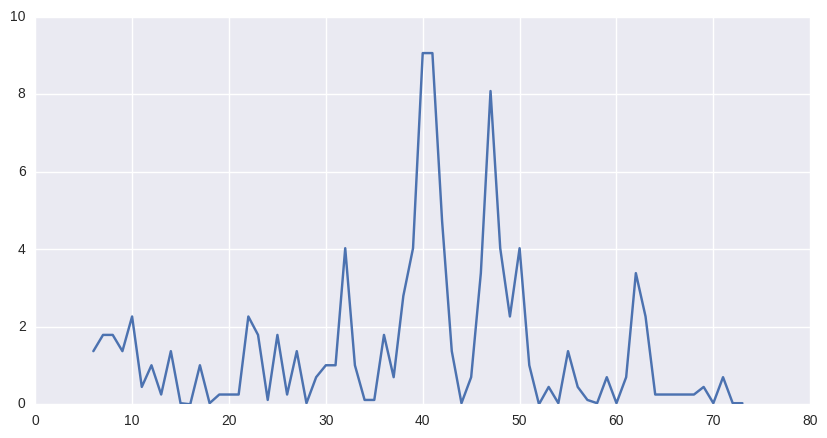

In [34]:
y = np.hstack((
    np.random.rand(40),
    np.random.rand(40) + 5
))

shift_detect = ShiftDetection(h=6, k=6)
shifts = shift_detect.find_shift(y)
shifts.sort_values(by='L', inplace=0, ascending=False)
    
fig = plt.figure(figsize=(10, 5))
plt.plot(shifts['t'].values, shifts['L'].values)